# JPEG Image Compression

### All Necessary Imports

In [32]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import os
import imageio.v3 as imageio
import pandas as pd

### Load Image
Loading the image for Compression

In [33]:


image_path = "Star.png"
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_size = os.path.getsize(image_path) / 1024  # in KB


### Jpeg Compression
Implmentating function for Compression

In [34]:
# JPEG Compression
def jpeg_compress(img, quality=10):
    out_path = 'compressed_jpeg.jpg'
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', cv2.cvtColor(img, cv2.COLOR_RGB2BGR), encode_param)
    with open(out_path, 'wb') as f:
        f.write(encimg.tobytes())
    compressed = cv2.imread(out_path)
    compressed = cv2.cvtColor(compressed, cv2.COLOR_BGR2RGB)
    size = os.path.getsize(out_path) / 1024
    return compressed, size

### Compress Images
Check the Image compression and Evaluating the metric for Compression

In [35]:
jpeg_img, jpeg_size = jpeg_compress(image)


# Metrics
def get_metrics(original, compressed):
    psnr = peak_signal_noise_ratio(original, compressed)
    ssim = structural_similarity(original, compressed, channel_axis=2)
    return psnr, ssim

jpeg_psnr, jpeg_ssim = get_metrics(image, jpeg_img)
jpeg_cr = original_size / jpeg_size

### Visualization
Visualy Comparing Both Image

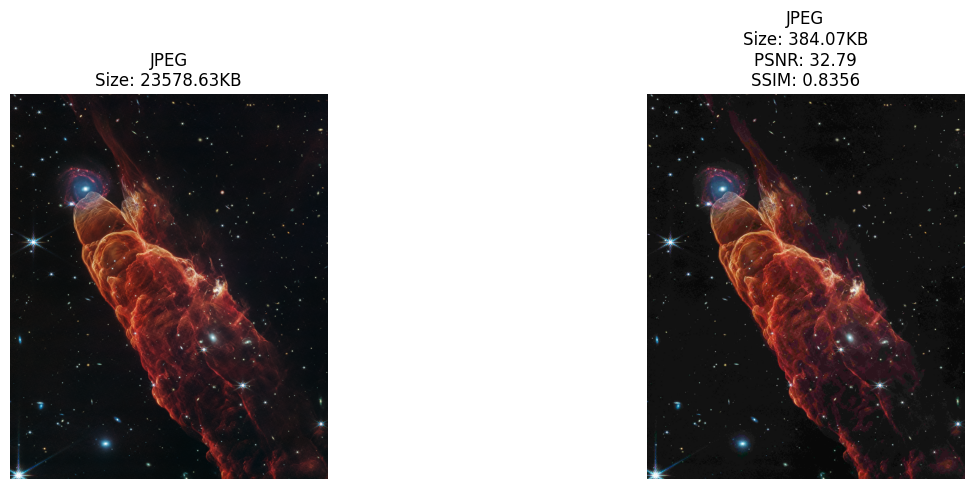

Original Size: 23578.63 KB
JPEG Size: 384.07 KB | PSNR: 32.79 | SSIM: 0.8356 | CR: 61.39


In [ ]:
# Visualization
plt.figure(figsize=(15, 5))

# Images
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.title(f"JPEG\nSize: {original_size:.2f}KB")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(jpeg_img)
plt.title(f"JPEG\nSize: {jpeg_size:.2f}KB\nPSNR: {jpeg_psnr:.2f}\nSSIM: {jpeg_ssim:.4f}")
plt.axis('off')


plt.tight_layout()
plt.show()

# Print Summary
print(f"Original Size: {original_size:.2f} KB")
print(f"JPEG Size: {jpeg_size:.2f} KB | PSNR: {jpeg_psnr:.2f} | SSIM: {jpeg_ssim:.4f} | CR: {jpeg_cr:.2f}")

# Campre the metric with compression ratio
jpeg_cr = original_size / jpeg_size
jpeg_psnr = peak_signal_noise_ratio(image, jpeg_img)
jpeg_ssim = structural_similarity(image, jpeg_img, channel_axis=2)
# Create a DataFrame to store the results
data = {
    'Compression Method': ['JPEG'],
    'Compression Ratio': [jpeg_cr],
    'PSNR': [jpeg_psnr],
    'SSIM': [jpeg_ssim]
}
# visulaize the metrics comparison
df = pd.DataFrame(data)
# Save the DataFrame to a CSV file
csv_path = 'compression_metrics.csv'
df.to_csv(csv_path, index=False)
# Read the CSV file
df = pd.read_csv(csv_path)
# Print the DataFrame
print(df)


# Jpeg 2000 Compression

In [29]:

# JPEG2000 Compression
def jpeg2000_compress(img, quality=10):
    out_path = 'compressed_jpeg2000.jp2'
    # Save with JPEG2000 compression
    imageio.imwrite(out_path, img, compression='JPEG2000', quality=quality)
    compressed = imageio.imread(out_path)
    size = os.path.getsize(out_path) / 1024
    return compressed, size

# Wavelet Compression
def wavelet_compress(img, wavelet='db1', level=3, threshold_factor=0.15):
    out_path = 'compressed_wavelet.jpg'
    img_ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    channels = cv2.split(img_ycbcr)
    compressed_channels = []
    
    for c in channels:
        coeffs = pywt.wavedec2(c, wavelet=wavelet, level=level)
        coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
        threshold = np.percentile(np.abs(coeff_arr), 100*(1-threshold_factor))
        coeff_arr = pywt.threshold(coeff_arr, threshold, mode='hard')
        coeffs_thresh = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
        compressed_c = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
        compressed_channels.append(np.clip(compressed_c, 0, 255))
    
    compressed = np.stack(compressed_channels, axis=2).astype(np.uint8)
    compressed = cv2.cvtColor(compressed, cv2.COLOR_YCrCb2RGB)
    cv2.imwrite(out_path, cv2.cvtColor(compressed, cv2.COLOR_RGB2BGR), 
                [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    size = os.path.getsize(out_path) / 1024
    return compressed, size



### Compression
Jpeg 200 and Wavlet Compression of the Image

In [30]:
# Compress Images
jpeg2000_img, jpeg2000_size = jpeg2000_compress(image)
wavelet_img, wavelet_size = wavelet_compress(image)

# Metrics
def get_metrics(original, compressed):
    psnr = peak_signal_noise_ratio(original, compressed)
    ssim = structural_similarity(original, compressed, channel_axis=2)
    return psnr, ssim

# Ensure all images have the same dimensions for metric calculation
min_h = min(image.shape[0], jpeg_img.shape[0], jpeg2000_img.shape[0], wavelet_img.shape[0])
min_w = min(image.shape[1], jpeg_img.shape[1], jpeg2000_img.shape[1], wavelet_img.shape[1])

image_cropped = image[:min_h, :min_w]
jpeg_img_cropped = jpeg_img[:min_h, :min_w]
jpeg2000_img_cropped = jpeg2000_img[:min_h, :min_w]
wavelet_img_cropped = wavelet_img[:min_h, :min_w]

jpeg_psnr, jpeg_ssim = get_metrics(image_cropped, jpeg_img_cropped)
jpeg2000_psnr, jpeg2000_ssim = get_metrics(image_cropped, jpeg2000_img_cropped)
wavelet_psnr, wavelet_ssim = get_metrics(image_cropped, wavelet_img_cropped)
jpeg_cr = original_size / jpeg_size
jpeg2000_cr = original_size / jpeg2000_size
wavelet_cr = original_size / wavelet_size

c:\Users\mohtr\AppData\Local\Programs\Python\Python313\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


### Visualization
visual Comparision of Images after compression

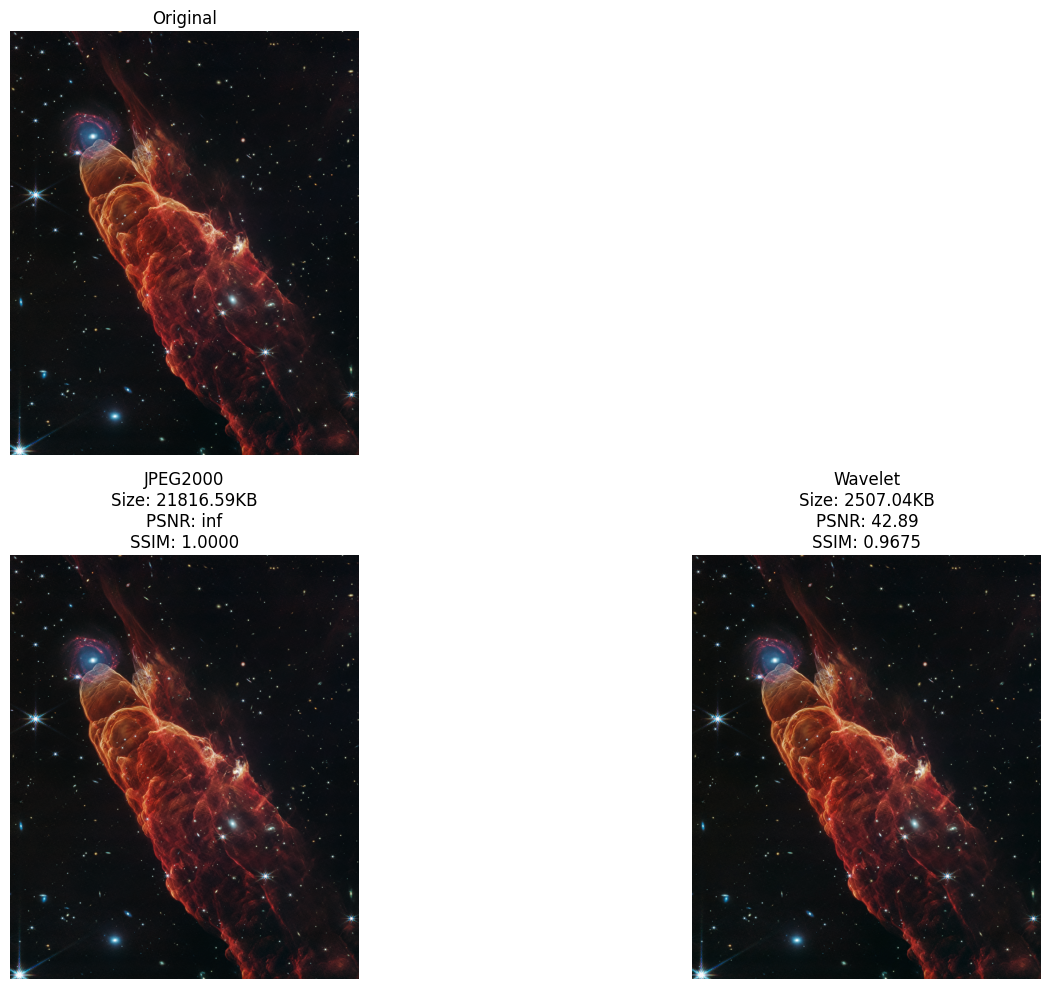

Original Size: 23578.63 KB
JPEG Size: 384.07 KB | PSNR: 32.79 | SSIM: 0.8356 | CR: 61.39
JPEG2000 Size: 21816.59 KB | PSNR: inf | SSIM: 1.0000 | CR: 1.08
Wavelet Size: 2507.04 KB | PSNR: 42.89 | SSIM: 0.9675 | CR: 9.40


In [ ]:
# Visualization
plt.figure(figsize=(15, 10))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

# JPEG2000
plt.subplot(1, 3, 2)
plt.imshow(jpeg2000_img)
plt.title(f"JPEG2000\nSize: {jpeg2000_size:.2f}KB\nPSNR: {jpeg2000_psnr:.2f}\nSSIM: {jpeg2000_ssim:.4f}")
plt.axis('off')

# Wavelet
plt.subplot(1, 3, 3)
plt.imshow(wavelet_img)
plt.title(f"Wavelet\nSize: {wavelet_size:.2f}KB\nPSNR: {wavelet_psnr:.2f}\nSSIM: {wavelet_ssim:.4f}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Print Summary
print(f"Original Size: {original_size:.2f} KB")
print(f"JPEG Size: {jpeg_size:.2f} KB | PSNR: {jpeg_psnr:.2f} | SSIM: {jpeg_ssim:.4f} | CR: {jpeg_cr:.2f}")
print(f"JPEG2000 Size: {jpeg2000_size:.2f} KB | PSNR: {jpeg2000_psnr:.2f} | SSIM: {jpeg2000_ssim:.4f} | CR: {jpeg2000_cr:.2f}")
print(f"Wavelet Size: {wavelet_size:.2f} KB | PSNR: {wavelet_psnr:.2f} | SSIM: {wavelet_ssim:.4f} | CR: {wavelet_cr:.2f}")

# Compare the summary in matrix form
summary_data = {
    'Method': ['JPEG', 'JPEG2000', 'Wavelet'],
    'Size (KB)': [jpeg_size, jpeg2000_size, wavelet_size],
    'PSNR': [jpeg_psnr, jpeg2000_psnr, wavelet_psnr],
    'SSIM': [jpeg_ssim, jpeg2000_ssim, wavelet_ssim],
    'CR': [jpeg_cr, jpeg2000_cr, wavelet_cr]
}
summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Method', inplace=True)
print("\nSummary DataFrame:")
print(summary_df)